Для построения модели предсказания превышения содержания мехпримесей в добываемом флюиде использовались производственные данные по параметрам работы добывающих скважин Восточно-Мессояхского месторождения.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

file_list = [
    "17.01.2020.xls", "27.03.2020.xls", "28.01.2021.xls", "30.03.2021.xls",
    "30.03.2022.xls", "30.06.2020.xls", "30.06.2021.xls", "30.06.2022.xls",
    "30.09.2020.xls", "30.09.2021.xls", "30.09.2022.xls", "31.01.2022.xls",
    "31.01.2023.xls", "31.03.2023.xls", "31.07.2023.xls"
]

data = pd.DataFrame()

# Загрузка всех файлов со списка, добавление колонки с датой измерения
for file in file_list:
    df = pd.read_excel(f"/kaggle/input/datasets123/{file}", skiprows=6, header=[0, 1, 2])
    df["Дата"] = file[:-4]
    data = pd.concat([data, df], ignore_index=True)

# Удаление столбцов, содержащих более 30% пропусков
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data.dropna(axis=1, thresh=0.7 * len(data))
data.columns = [
    ' '.join([part for part in col if not part.startswith('Unnamed')]).strip()
    for col in data.columns
]

# Оставляем только действующие нефтяные скважины пласта ПК1-3
data = data[(data["Месторождение Код"].notna()) & (data['Месторождение Код'] == 11.0) 
& (data["Пласт"] == "ПК1-3") & (data['Назначение по проекту'] == "Нефтяные")]
data = data.sort_values(["№\nскв", "Дата"])
data = data.loc[:, data.nunique() > 1]
data = data[[data.columns[-1]] + [col for col in data.columns[:-1]]]
# Кодировка переменных типа скважины и системы эксплуатации
data['is_horis'] = np.where(data['Тип\nскважины'] == 'ГОР', 1, 0)
data['is_ESP'] = np.where(data['СЭ'] == 'ЭЦН', 1, 0)

# Аналитически отобраны признаки, которые точно не влияют на предсказание
to_drop = ['Тип насоса', 'ПЭД Марка', 'ГЗУ', 'Тип ГЗУ', 'Дата запуска после КРС', 'Дата остановки', 
           'Дата ввода в эксплу-атацию', 'Режим работы УЭЦН Комментарии', 'Режим работы УЭЦН Дата установки режима Описание', 'СЭ', 'Тип скважины']

to_drop_2 = ['Р пл на ВДП', 'Куст', 'Дата запуска', 'Группа фонда', 'Дополнительное оборудование Диаметр', 
             'Дополнительное оборудование Глубина спуска', 'Режим работы УЭЦН Режим', 'Режим работы УЭЦН Дата установки режима',
            'Номинальная производительность', 'Номинальный напор', 'Номинальный напор', 'Состояние на конец месяца',
            'Сравнение расчетов потенциала dQж при ГРП', 'Сравнение расчетов потенциала dQж при ГРП с корр',
            'Рзаб (геол огр индив)', 'Планируемый режим Q пг', 'ГФ', 'F', 'ГРП JD факт.',
            'Время до псевдоустановившегося режима', 'D э/к', 'D нкт', 'D шт']

# Удаление лишних симоволов в названии колонок, изменен тип данных на int
data.columns = data.columns.str.replace(r'\n', ' ', regex=True)
data = data.replace(r'[^0-9]', '', regex=True)
dat = data['Дата']
data = data.drop(columns=['Дата']).apply(pd.to_numeric, errors='coerce')
data['Дата'] = pd.to_datetime(dat)

# Группировка данных по скважинам, заполнение пропусков средним значением
well_column = "№ скв"
data.iloc[:, 1:] = data.groupby(well_column).transform(lambda x: x.fillna(x.median()))

# Удаление выбросов в целовоей переменной КВЧ
data = data.drop(columns=(to_drop + to_drop_2))
data = data[data['Содер-жание мех-примесей (КВЧ)'] < 2000]
data = data.dropna()

# Добавим новые признаки - разность пастового давление и дебита на скважине на двух соседних временных промежутках
data['P пл разность'] = data.groupby(well_column)['Р пл'].diff()
data['Qтеор разность'] = data.groupby(well_column)['Qтеор'].diff()
data['P пл разность'] = data['P пл разность'].fillna(0)
data['Qтеор разность'] = data['Qтеор разность'].fillna(0)


data

<ipython-input-1-342c8c6dda95>:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(r'[^0-9]', '', regex=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


,№ скв,Н вдп,Удл,Н сп,Р буф,Р лин,Р пл,Н д,P затр,Р на приёме,...,Сравнение расчетов потенциала dQж при ИДН,Сравнение расчетов потенциала dQж при ИДН с корр,Сравнение расчетов потенциала dQн при ИДН,Удл (Нсп),Удл (Нд),is_horis,is_ESP,Дата,P пл разность,Qтеор разность
223,102,1277.41,428.39,789.498,37.0,33.0,70.399,430.0,36.0,35.64,...,30.992624,31.000000,14.354550,86.47,0.69,1,1,2020-01-17,0.0,0.0
604,102,1277.41,428.39,789.498,37.0,31.5,68.199,425.0,35.0,36.06,...,39.999712,40.000000,18.900000,86.47,0.60,1,1,2020-03-27,-2.2,-72.0
2440,102,1277.41,428.39,789.498,32.0,30.8,68.999,561.0,31.5,36.00,...,52.004084,52.004084,21.623298,86.47,11.09,1,1,2020-06-30,0.8,32.0
3866,102,1277.41,428.39,789.498,36.0,33.2,70.399,585.0,36.5,28.26,...,101.607929,101.607929,42.248577,86.47,14.61,1,1,2020-09-30,1.4,16.0
1014,102,1277.41,428.39,792.350,30.0,26.6,62.399,692.0,28.0,31.19,...,39.637355,39.637355,14.982920,87.92,39.76,1,1,2021-01-28,-8.0,-53.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,92,1030.05,201.93,807.180,13.0,10.4,58.697,450.0,11.0,35.71,...,43.921277,43.921277,24.903364,70.48,0.43,1,1,2022-06-30,-1.4,0.0
4812,92,1030.05,201.93,807.180,12.0,9.6,60.997,438.0,11.0,36.58,...,52.457196,52.457196,27.264628,70.48,0.22,1,1,2022-09-30,2.3,2.0
5891,92,1030.05,201.93,807.180,12.0,10.2,59.197,554.0,14.0,33.64,...,25.452001,25.452001,13.228678,70.48,4.07,1,1,2023-01-31,-1.8,-30.0
6466,92,1030.05,201.93,807.180,12.0,10.4,57.297,507.0,12.0,31.55,...,41.042110,41.042110,21.331637,70.48,1.91,1,1,2023-03-31,-1.9,12.0


Рассмотрим распределение целевой переменной после удаления выбросов

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Содер-жание мех-примесей (КВЧ)', ylabel='Density'>

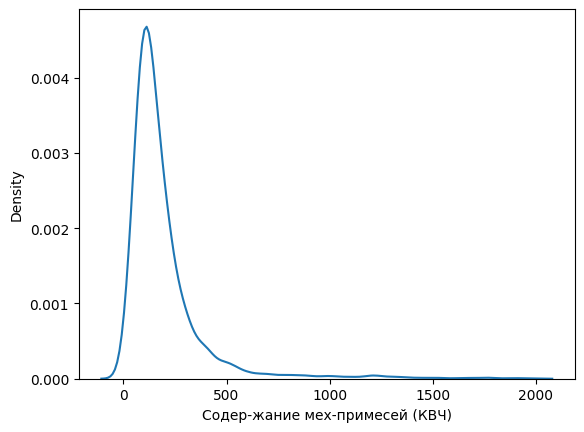

In [4]:
sns.kdeplot(data['Содер-жание мех-примесей (КВЧ)'])

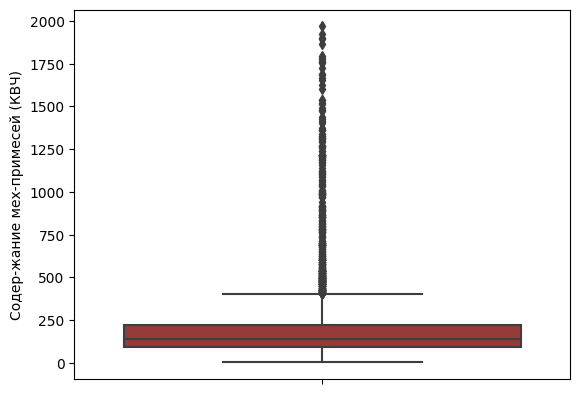

In [5]:
sns.boxplot(y=data['Содер-жание мех-примесей (КВЧ)'], color='brown');

Учитывая, что распределение выглядит как нормальное, но с правым вытянутым хвостом, можно выбрать критическое значение КВЧ как значение, превышающее примерно 2 стандартных отклонения от среднего. 
Критическое значение=μ+2⋅σ — это подход, основанный на характеристиках нормального распределения, который часто используется в статистике для оценки "экстремальных" значений данных, а именно значений, которые значительно отклоняются от средней величины.

In [6]:
# Расчитаем критическое значение
critic = data['Содер-жание мех-примесей (КВЧ)'].mean() + 2 * data['Содер-жание мех-примесей (КВЧ)'].std()

# Добавление целового класса - наличие пескопроявления
data['CRITIC_TSP'] = np.where(data['Содер-жание мех-примесей (КВЧ)'] > critic, 1, 0)
data

,№ скв,Н вдп,Удл,Н сп,Р буф,Р лин,Р пл,Н д,P затр,Р на приёме,...,Сравнение расчетов потенциала dQж при ИДН с корр,Сравнение расчетов потенциала dQн при ИДН,Удл (Нсп),Удл (Нд),is_horis,is_ESP,Дата,P пл разность,Qтеор разность,CRITIC_TSP
223,102,1277.41,428.39,789.498,37.0,33.0,70.399,430.0,36.0,35.64,...,31.000000,14.354550,86.47,0.69,1,1,2020-01-17,0.0,0.0,0
604,102,1277.41,428.39,789.498,37.0,31.5,68.199,425.0,35.0,36.06,...,40.000000,18.900000,86.47,0.60,1,1,2020-03-27,-2.2,-72.0,0
2440,102,1277.41,428.39,789.498,32.0,30.8,68.999,561.0,31.5,36.00,...,52.004084,21.623298,86.47,11.09,1,1,2020-06-30,0.8,32.0,0
3866,102,1277.41,428.39,789.498,36.0,33.2,70.399,585.0,36.5,28.26,...,101.607929,42.248577,86.47,14.61,1,1,2020-09-30,1.4,16.0,0
1014,102,1277.41,428.39,792.350,30.0,26.6,62.399,692.0,28.0,31.19,...,39.637355,14.982920,87.92,39.76,1,1,2021-01-28,-8.0,-53.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,92,1030.05,201.93,807.180,13.0,10.4,58.697,450.0,11.0,35.71,...,43.921277,24.903364,70.48,0.43,1,1,2022-06-30,-1.4,0.0,0
4812,92,1030.05,201.93,807.180,12.0,9.6,60.997,438.0,11.0,36.58,...,52.457196,27.264628,70.48,0.22,1,1,2022-09-30,2.3,2.0,0
5891,92,1030.05,201.93,807.180,12.0,10.2,59.197,554.0,14.0,33.64,...,25.452001,13.228678,70.48,4.07,1,1,2023-01-31,-1.8,-30.0,0
6466,92,1030.05,201.93,807.180,12.0,10.4,57.297,507.0,12.0,31.55,...,41.042110,21.331637,70.48,1.91,1,1,2023-03-31,-1.9,12.0,0


Рассмотрим распределение классов целевой переменной. Классы выглядят несбалансированными. Возможно стоит использовать метода oversampling или undersampling, если результат модели на валидационной выборке будет не очень хорошим

<Axes: xlabel='CRITIC_TSP', ylabel='count'>

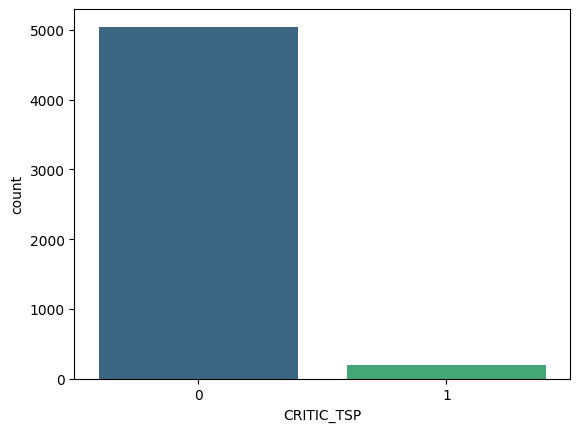

In [11]:
sns.countplot(x=data['CRITIC_TSP'], palette='viridis')

Будем обучать модель CatBoostClassifier с использованием метрики AUC, оценивать точность будем по ROC-AUC score. Используем optuna для подбора оптимальных гиперпараметров.

In [ ]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score


# Определяем столбцы, которые не будем использовать в качестве признаков
exclude_cols = ['Содер-жание мех-примесей (КВЧ)', 'Дата', 'CRITIC_TSP']
X = data.drop(columns=exclude_cols)
y = data['CRITIC_TSP']

def objective(trial):
    # Задаём пространство гиперпараметров для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 50, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'random_seed': 54,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': False 
    }
    
    model = CatBoostClassifier(**params)
    
    # StratifiedKFold для сохранения пропорций классов в фолдах
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # кросс-валидация с метрикой ROC-AUC
    scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    
    # Используем среднее значение ROC-AUC по всем фолдам
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
# Запуск оптимизации на 100 испытаниях
study.optimize(objective, n_trials=100)

print("Best ROC-AUC:", study.best_value)
print("Best parameters:", study.best_params)


Обчение модели с использованием оптимальных параметров полученных из optuna

In [17]:
exclude_cols = ['Содер-жание мех-примесей (КВЧ)', 'Дата', 'CRITIC_TSP']

X = data.drop(columns=exclude_cols)
y = data['CRITIC_TSP']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Формируем пулы данных для CatBoost
train_pool = Pool(X_train, y_train)
eval_pool = Pool(X_test, y_test)

# Создаём модель CatBoostClassifier с указанием метрики AUC
model = CatBoostClassifier(
    iterations=249,
    learning_rate=0.05,
    depth=4,
    l2_leaf_reg=10,
    loss_function='Logloss',   # логарифмическая функция потерь для классификации
    eval_metric='AUC',         # используем ROC-AUC как метрику
    random_seed=42,
    verbose=100
)

# Обучаем модель с ранней остановкой по валидационному набору
model.fit(train_pool,
          eval_set=eval_pool,
          early_stopping_rounds=50)

# Предсказываем вероятности для тестовой выборки
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Оцениваем качество модели по ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC score: ", roc_auc)

0:	test: 0.7491677	best: 0.7491677 (0)	total: 5.12ms	remaining: 1.27s
100:	test: 0.8005133	best: 0.8019110 (97)	total: 419ms	remaining: 614ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8019110061
bestIteration = 97

Shrink model to first 98 iterations.
ROC-AUC score:  0.8019110060735433


Рассмотрим наиболее важные признаки для модели. Таким образом, наибольшее влияние оказывают: глубина забоя скважины, межремонтный период, пластовое давление, плотность раствора глушения, вязкость добываемого флюида и его обводненность.

0:	total: 4.79ms	remaining: 709ms
100:	total: 427ms	remaining: 203ms
148:	total: 659ms	remaining: 0us


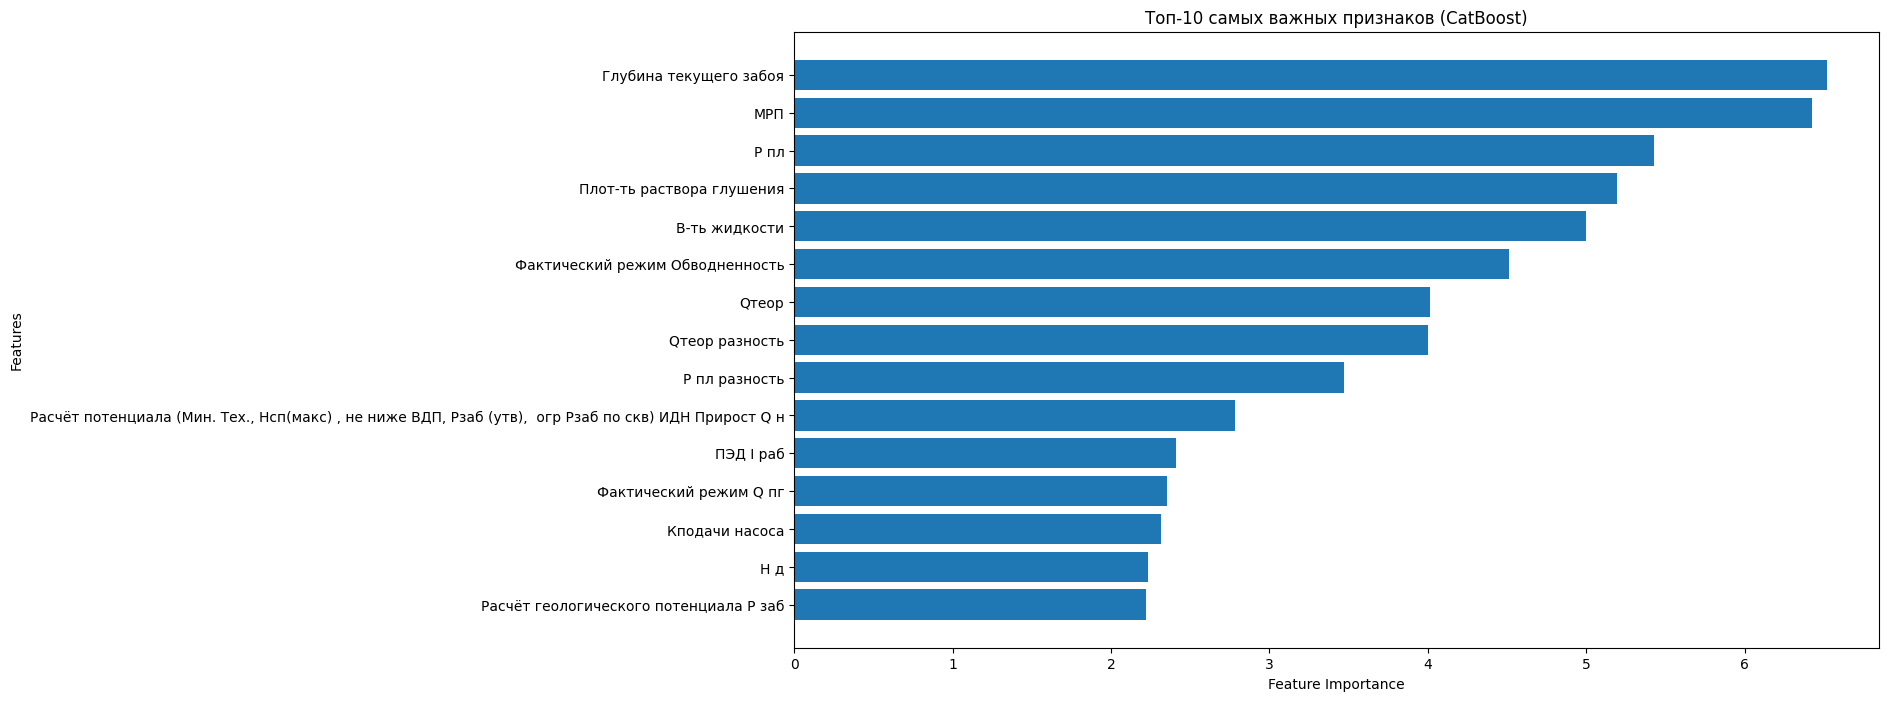

In [18]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt


exclude_cols = ['Содер-жание мех-примесей (КВЧ)', 'Дата', 'CRITIC_TSP']
X = data.drop(columns=exclude_cols)
y = data['CRITIC_TSP']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = CatBoostClassifier(
    iterations=149,
    learning_rate=0.05,
    depth=4,
    l2_leaf_reg=10,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train)

feature_importance = model.get_feature_importance()
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(14, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Топ-10 самых важных признаков (CatBoost)")
plt.gca().invert_yaxis()
plt.show()

Построим получившуюся roc-curve. Площадь под кривой равно около 0,8

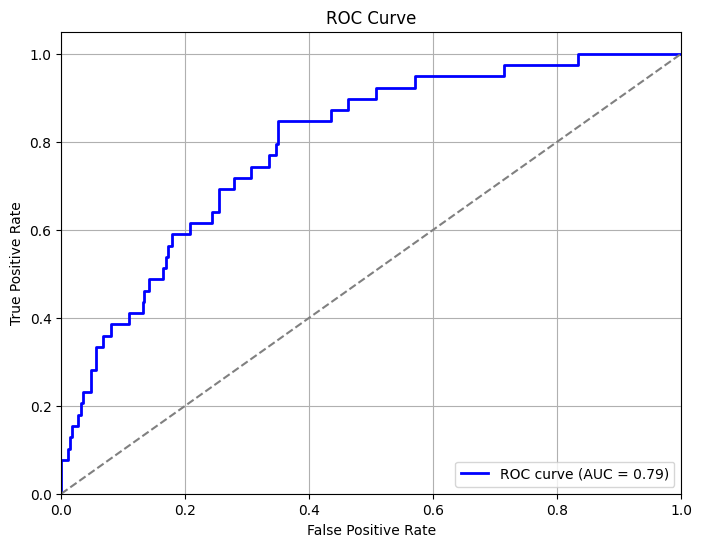

In [20]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
